In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
# set a working directory
wdir = "/Acropora_sc_analysis/scenic_analysis/ahem_TF_analysis/analysis_on_promoter5k/input_data/"
os.chdir( wdir )

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "ahem_counts.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "ahem_counts.loom"

# path to pyscenic output
f_pyscenic_output = "ahem_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'ahem_scenic_integrated-output.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

In [5]:
# read the original loom data
import seaborn as sns
import matplotlib.pyplot as plt

adata = sc.read_h5ad('ahem_counts.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 4716 × 33509
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'UMI_count_algae', 'gene_count_algae', 'row_name', 'integrated_snn_res.0.08', 'seurat_clusters', 'algae_ratio', 'Cell_type'
    var: 'features'

In [7]:
np.array(adata.raw)

array(<anndata._core.raw.Raw object at 0x2ae628470f10>, dtype=object)

## Basic filtering

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  17400.919047652296
Number of cells in which each gene is detected: 0  -  3981


In [10]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  141.48
minSamples:  47.160000000000004


In [11]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
#mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
#adata.obs['percent_mito'] = np.sum(
#    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [12]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,UMI_count_algae,gene_count_algae,row_name,integrated_snn_res.0.08,seurat_clusters,algae_ratio,Cell_type,n_genes,n_counts
AAACCCAAGAAGTGTT-1_1,A1,219.0,193,0.0,0.0,AAACCCAAGAAGTGTT-1_1,0,1.0,0.000000,Unknown,193,758.009778
AAACCCACATACCGTA-1_1,A1,701.0,530,1.0,1.0,AAACCCACATACCGTA-1_1,1,2.0,0.001425,Gastrodermal cell,530,1521.724507
AAACCCACATTCATCT-1_1,A1,738.0,536,0.0,0.0,AAACCCACATTCATCT-1_1,0,1.0,0.000000,Unknown,536,1532.298139
AAACGAAAGACGTCGA-1_1,A1,228.0,170,0.0,0.0,AAACGAAAGACGTCGA-1_1,2,3.0,0.000000,Calicoblast,170,677.932292
AAACGAAGTAGCTTAC-1_1,A1,1130.0,754,0.0,0.0,AAACGAAGTAGCTTAC-1_1,4,5.0,0.000000,Neurons,754,1871.899607
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGCAGCTA-1_3,A3,319.0,259,0.0,0.0,TTTGTTGAGGCAGCTA-1_3,1,2.0,0.000000,Gastrodermal cell,259,929.295254
TTTGTTGCACGAAAGC-1_3,A3,221.0,202,0.0,0.0,TTTGTTGCACGAAAGC-1_3,4,5.0,0.000000,Neurons,202,784.442681
TTTGTTGTCAGCTTCC-1_3,A3,346.0,261,0.0,0.0,TTTGTTGTCAGCTTCC-1_3,1,2.0,0.000000,Gastrodermal cell,261,920.635901
TTTGTTGTCCACATAG-1_3,A3,336.0,282,0.0,0.0,TTTGTTGTCCACATAG-1_3,2,3.0,0.000000,Calicoblast,282,997.013466


In [13]:
min(adata.obs['n_counts'])

458.9012950979045

### Diagnostic plots, pre-filtering

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/zhonh0b/anaconda3/e

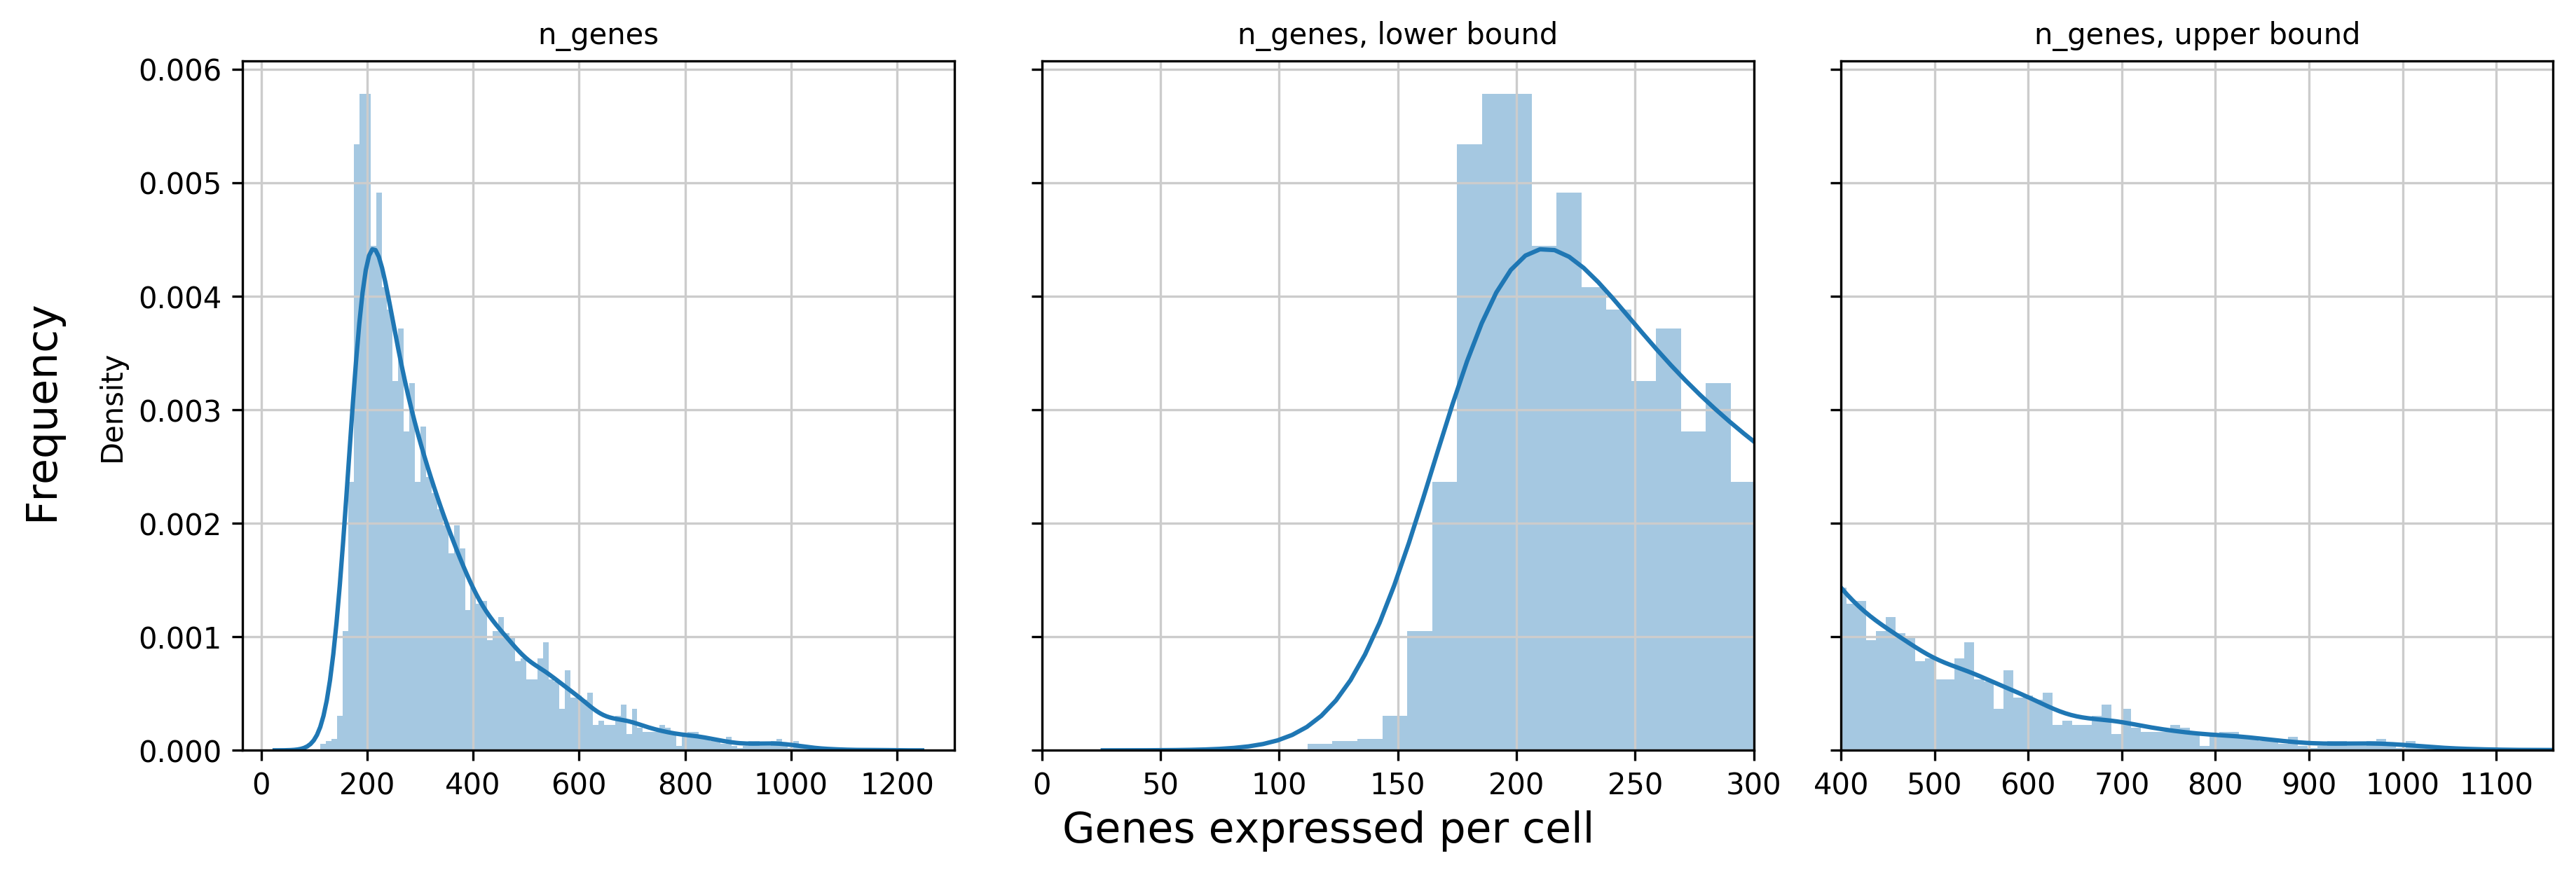

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 300
x_upperbound = 400
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/zhonh0b/anaconda3/e

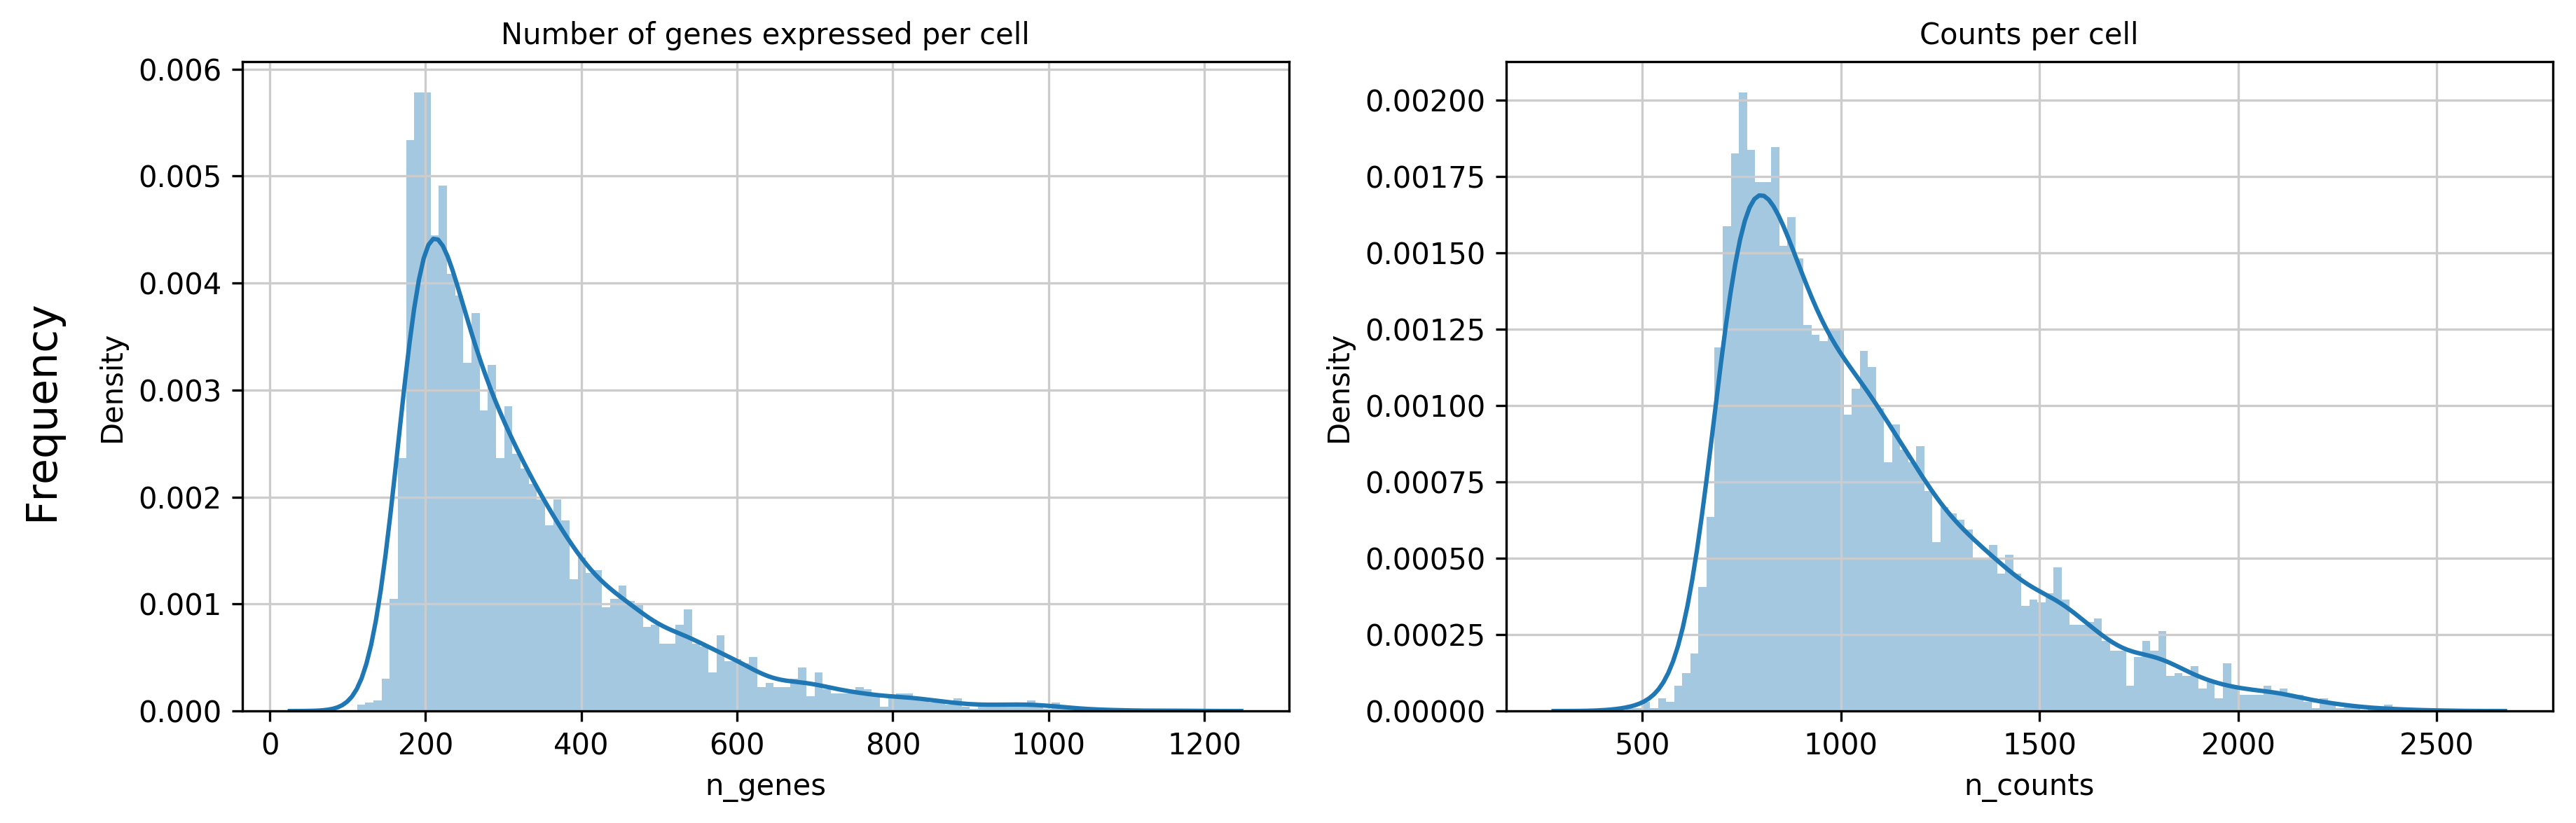

In [15]:
## summary plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
#sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
#ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

#fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Cell_type' as categorical
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("

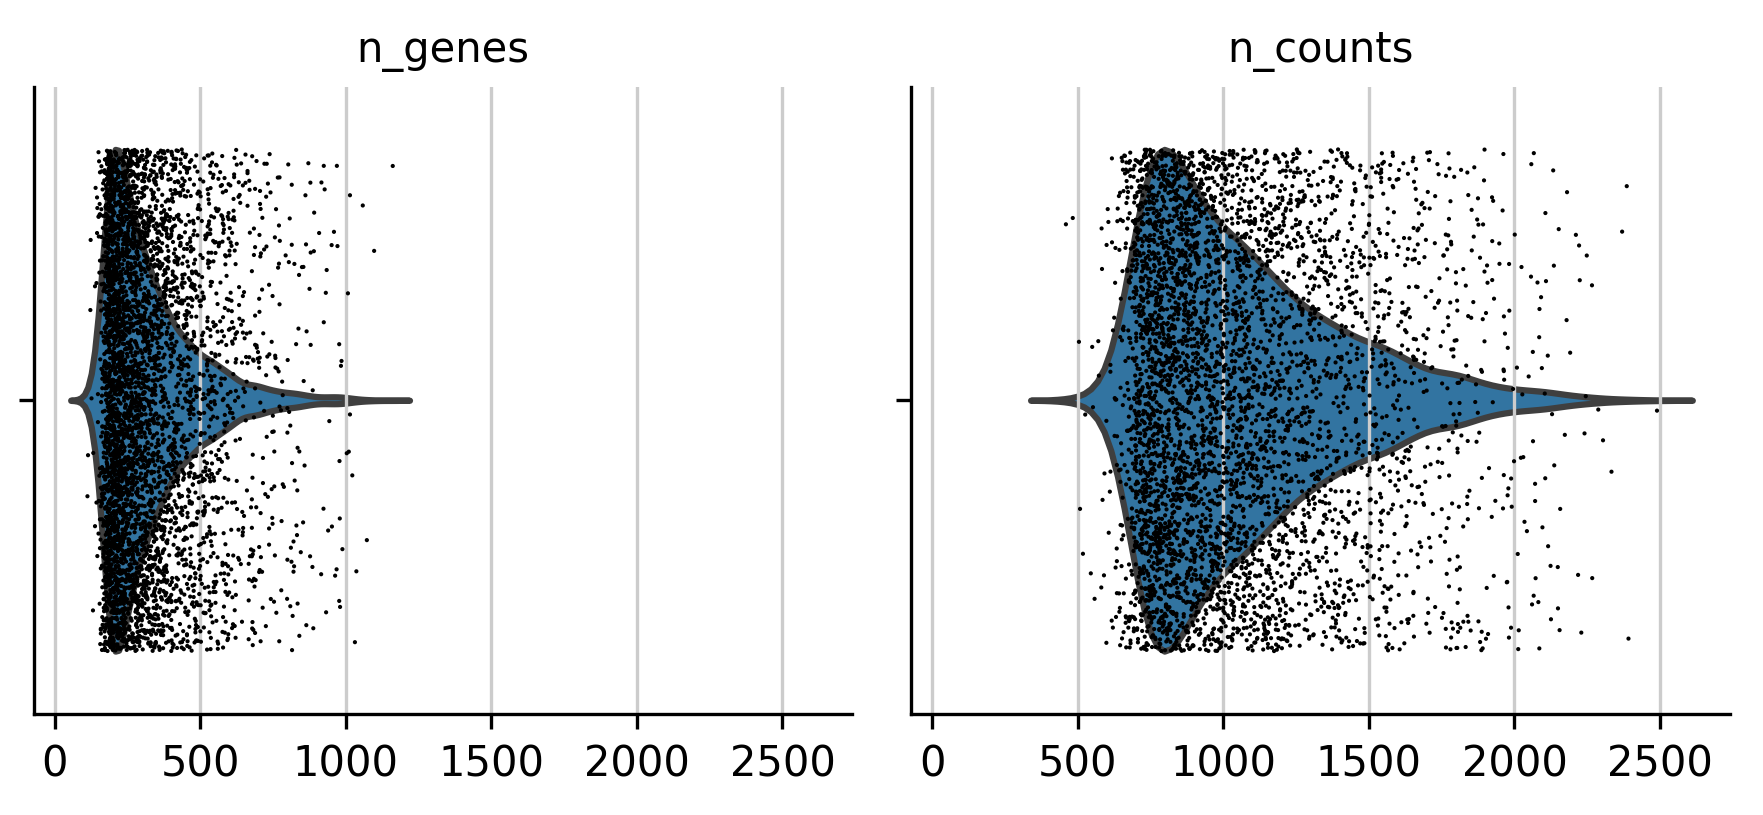

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True )

## filtering 

In [17]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=50 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 16230 genes that are detectedin less than 3 cells


In [18]:
adata

AnnData object with n_obs × n_vars = 4716 × 17279
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'UMI_count_algae', 'gene_count_algae', 'row_name', 'integrated_snn_res.0.08', 'seurat_clusters', 'algae_ratio', 'Cell_type', 'n_genes', 'n_counts'
    var: 'features', 'n_cells'

In [19]:
adata = adata[adata.obs['n_genes'] < 700, :]

In [20]:
adata

View of AnnData object with n_obs × n_vars = 4541 × 17279
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'UMI_count_algae', 'gene_count_algae', 'row_name', 'integrated_snn_res.0.08', 'seurat_clusters', 'algae_ratio', 'Cell_type', 'n_genes', 'n_counts'
    var: 'features', 'n_cells'

### Diagnostic plots, post filtering

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/zhonh0b/anaconda3/e

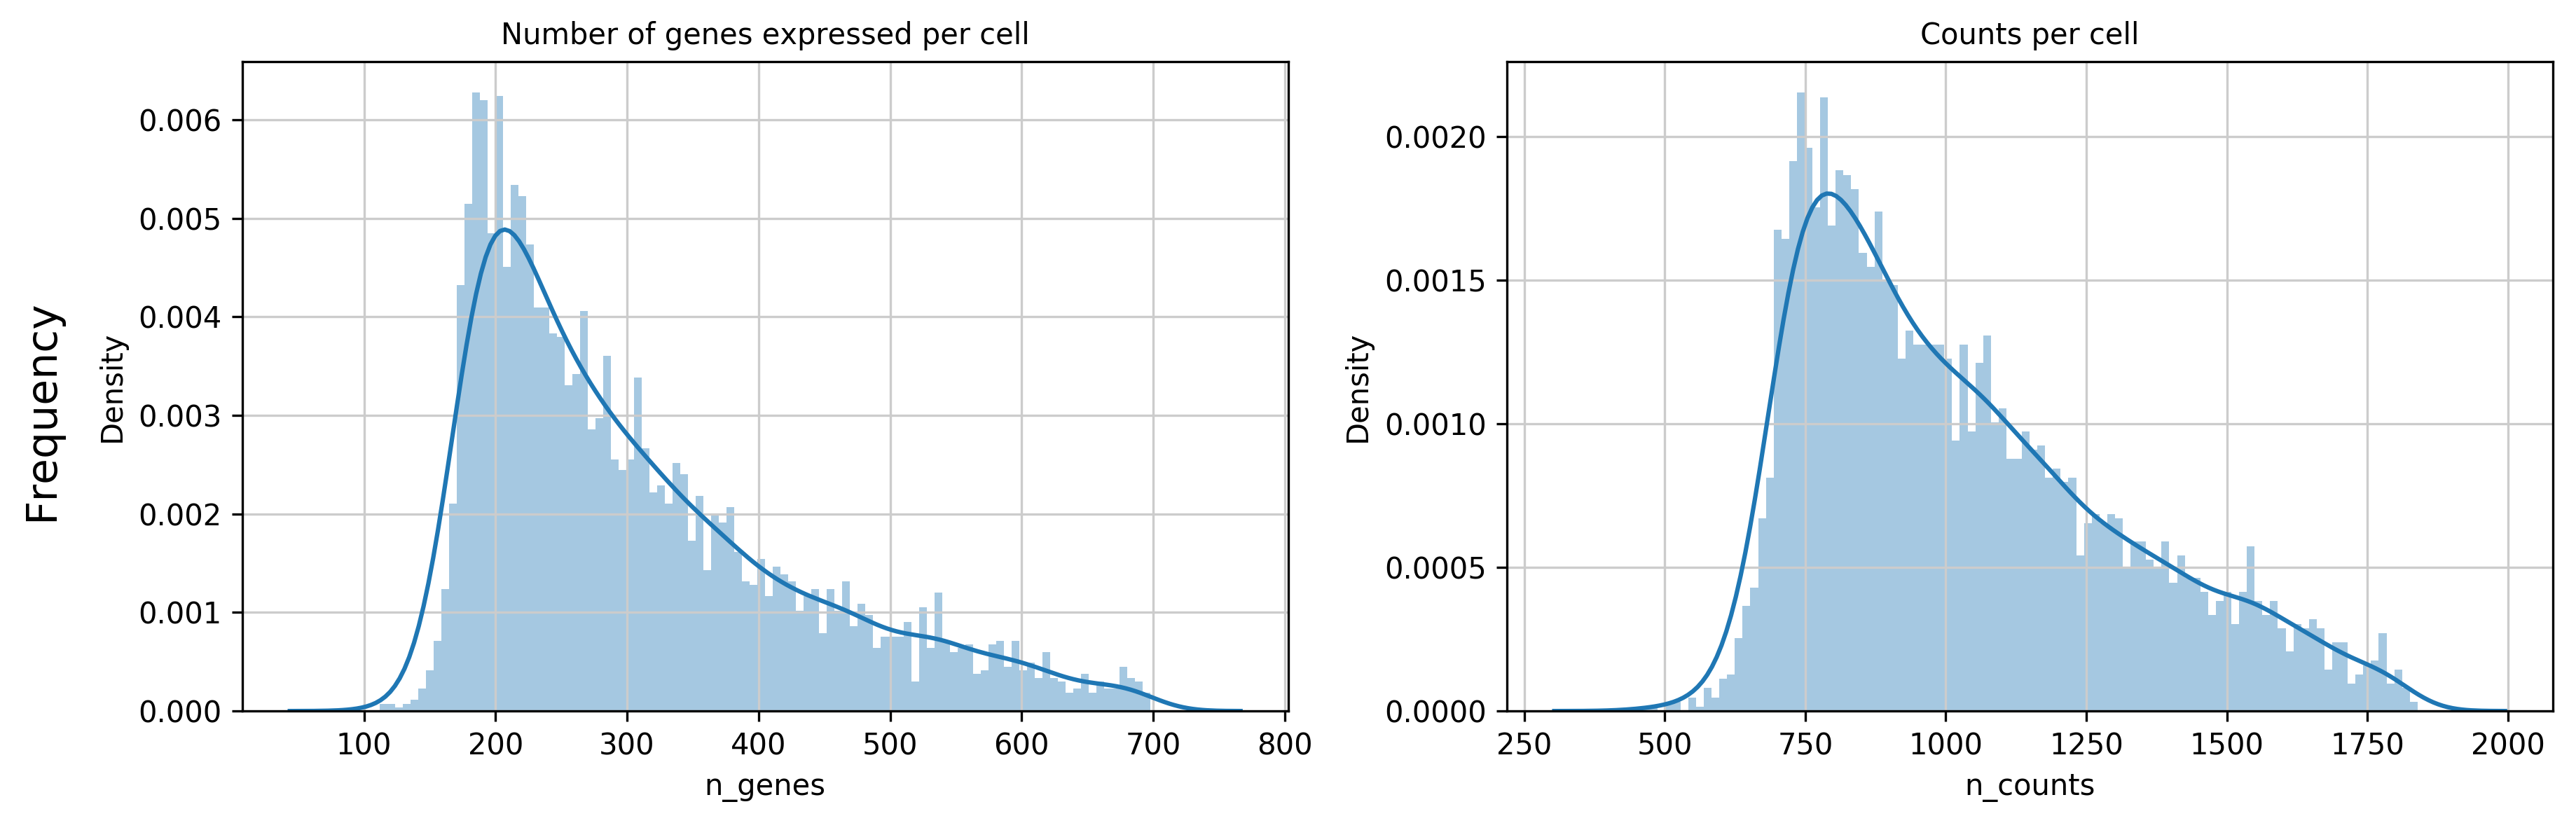

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
#sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
#ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

#fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


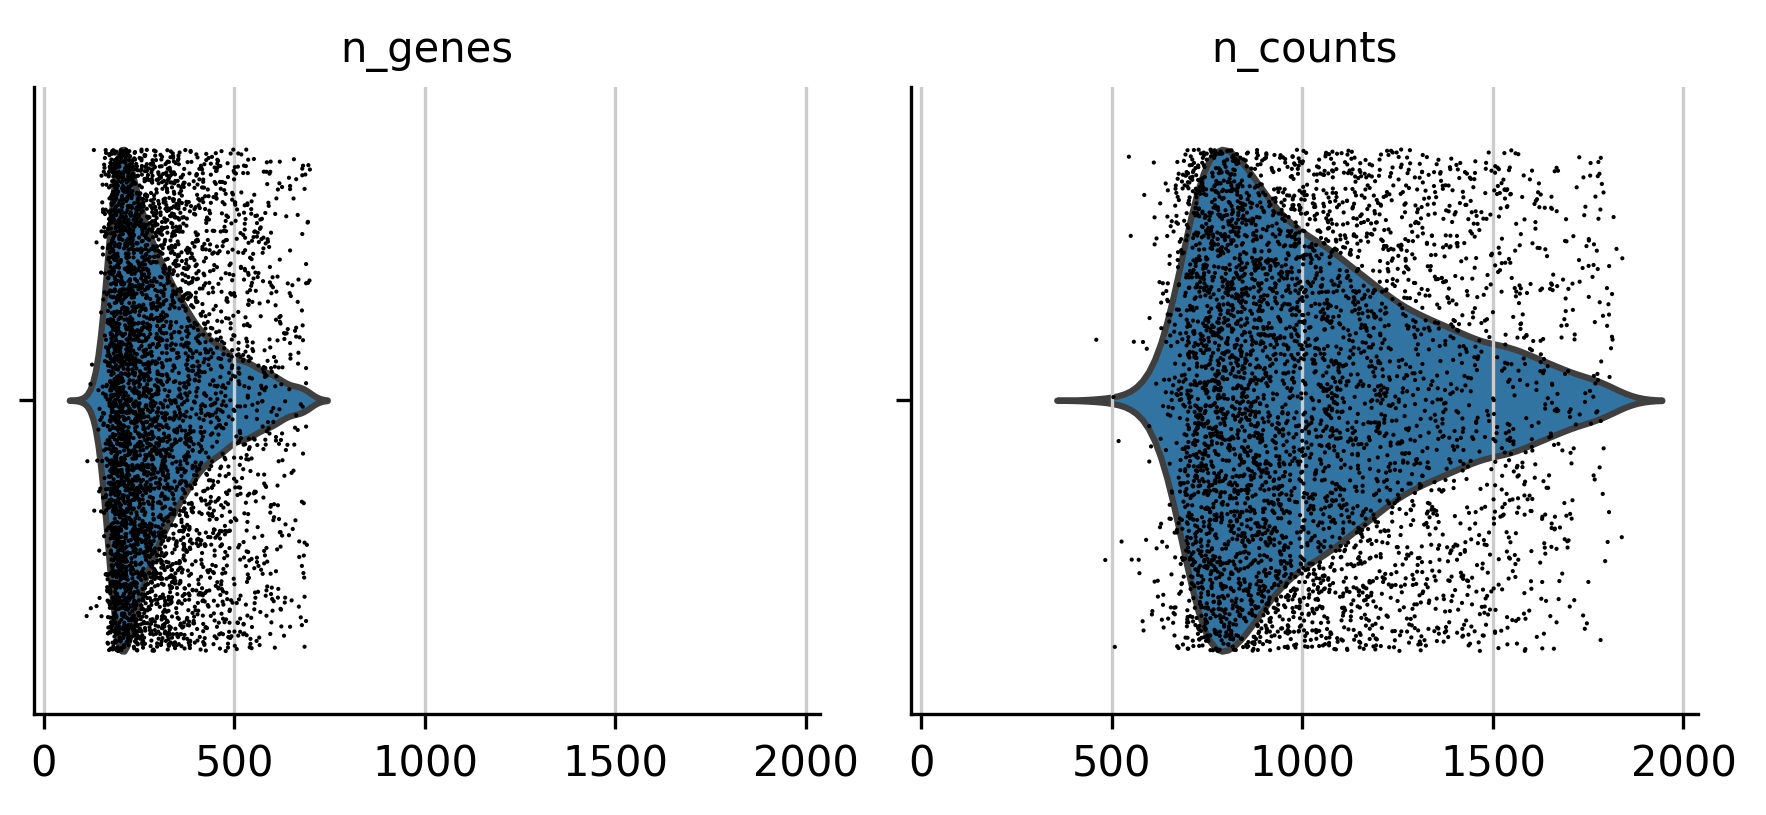

In [22]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],
    jitter=0.4, multi_panel=True )

In [23]:
adata

View of AnnData object with n_obs × n_vars = 4541 × 17279
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'UMI_count_algae', 'gene_count_algae', 'row_name', 'integrated_snn_res.0.08', 'seurat_clusters', 'algae_ratio', 'Cell_type', 'n_genes', 'n_counts'
    var: 'features', 'n_cells'

In [24]:
adata_origin=sc.read_h5ad("ahem.h5ad")

In [25]:
selected_names=list(adata.obs.index)

In [26]:
adata_origin

AnnData object with n_obs × n_vars = 4716 × 33509
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'UMI_count_algae', 'gene_count_algae', 'row_name', 'integrated_snn_res.0.08', 'seurat_clusters', 'algae_ratio', 'Cell_type'
    var: 'features'
    obsm: 'X_tsne', 'X_umap'

In [27]:
X_umap=pd.DataFrame(adata_origin.obsm['X_umap'],index=adata_origin.obs.index)
X_tsne=pd.DataFrame(adata_origin.obsm['X_tsne'],index=adata_origin.obs.index)

In [28]:
X_umap=X_umap[X_umap.index.isin(selected_names)]
X_tsne=X_tsne[X_tsne.index.isin(selected_names)]

In [29]:
adata.obsm['X_tsne']=X_tsne.to_numpy()
adata.obsm['X_umap']=X_umap.to_numpy()

In [30]:
adata

AnnData object with n_obs × n_vars = 4541 × 17279
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'UMI_count_algae', 'gene_count_algae', 'row_name', 'integrated_snn_res.0.08', 'seurat_clusters', 'algae_ratio', 'Cell_type', 'n_genes', 'n_counts'
    var: 'features', 'n_cells'
    obsm: 'X_tsne', 'X_umap'

In [31]:
adata.__dict__['_raw'].__dict__['_var'] = adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [32]:
adata.write( 'ahem_filtered.h5ad' )

In [33]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    "group": np.array(adata.obs['orig.ident']),
    "seurat_clusters": np.array(adata.obs['seurat_clusters']),
    "Cell_type": np.array(adata.obs['Cell_type']),
    'orig.ident': np.array(adata.obs['orig.ident'])
}
lp.create( 'ahem_filtered.loom', adata.X.transpose(), row_attrs, col_attrs)

# SCECNIC step

## STEP 1: Gene regulatory network inference, and generation of co-expression modules
### Phase Ia: GRN inference using the GRNBoost2 algorithm

In [34]:
f_loom_path_scenic="ahem_filtered.loom"

In [ ]:
# transcription factors list
f_tfs = "/Acropora_sc_analysis/scenic_analysis/ahem_TF_analysis/TF_data/ahem_TF_list.txt" # aiptasia

In [36]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o ../output_data/adj.csv --num_workers 20

# I compute this in the linux 


2023-04-20 13:46:50,512 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-04-20 13:46:52,195 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork fro

In [37]:
adjacencies = pd.read_csv("../output_data/adj.csv", index_col=False, sep=',')

In [38]:
adjacencies.head()

,TF,target,importance
0,g26768,g5093,149.029662
1,g26768,g20294,140.715243
2,g26768,g23288,133.236958
3,g26768,g29363,131.558093
4,g26768,g10168,128.901173


# STEP 2-3: Regulon prediction aka cisTarget from CLI

In [ ]:
import glob
# ranking databases
f_db_glob="/Acropora_sc_analysis/scenic_analysis/create_cisTarget_databases/ahem_promoter_5k/ahem.regions_vs_motifs.rankings.feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path="/Acropora_sc_analysis/scenic_analysis/create_cisTarget_databases/ahem_motif.tbl"

In [41]:
f_loom_path_scenic

'ahem_filtered.loom'

In [78]:
!pyscenic ctx ../output_data/adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output ../output_data/reg.csv \
    --mask_dropouts \
    --no_pruning \
    --num_workers 20


2023-04-17 19:22:09,673 - pyscenic.cli.pyscenic - INFO - Creating modules.

2023-04-17 19:22:10,104 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-04-17 19:22:12,086 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-04-17 19:22:12,276 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2023-04-17 19:22:34,168 - pyscenic.utils - INFO - Creating modules.

2023-04-17 19:24:47,051 - pyscenic.cli.pyscenic - IN

# STEP 4: Cellular enrichment (aka AUCell) from CLI

In [42]:
f_loom_path_scenic

'ahem_filtered.loom'

In [43]:
adata = sc.read_loom( f_loom_path_scenic,validate=False) 
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)

In [44]:
nGenesDetectedPerCell=pd.DataFrame(nGenesDetectedPerCell)

In [45]:
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

          0
0.01  158.0
0.05  175.0
0.10  185.0
0.50  271.0
1.00  696.0


In [46]:
percentiles=percentiles[0]

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


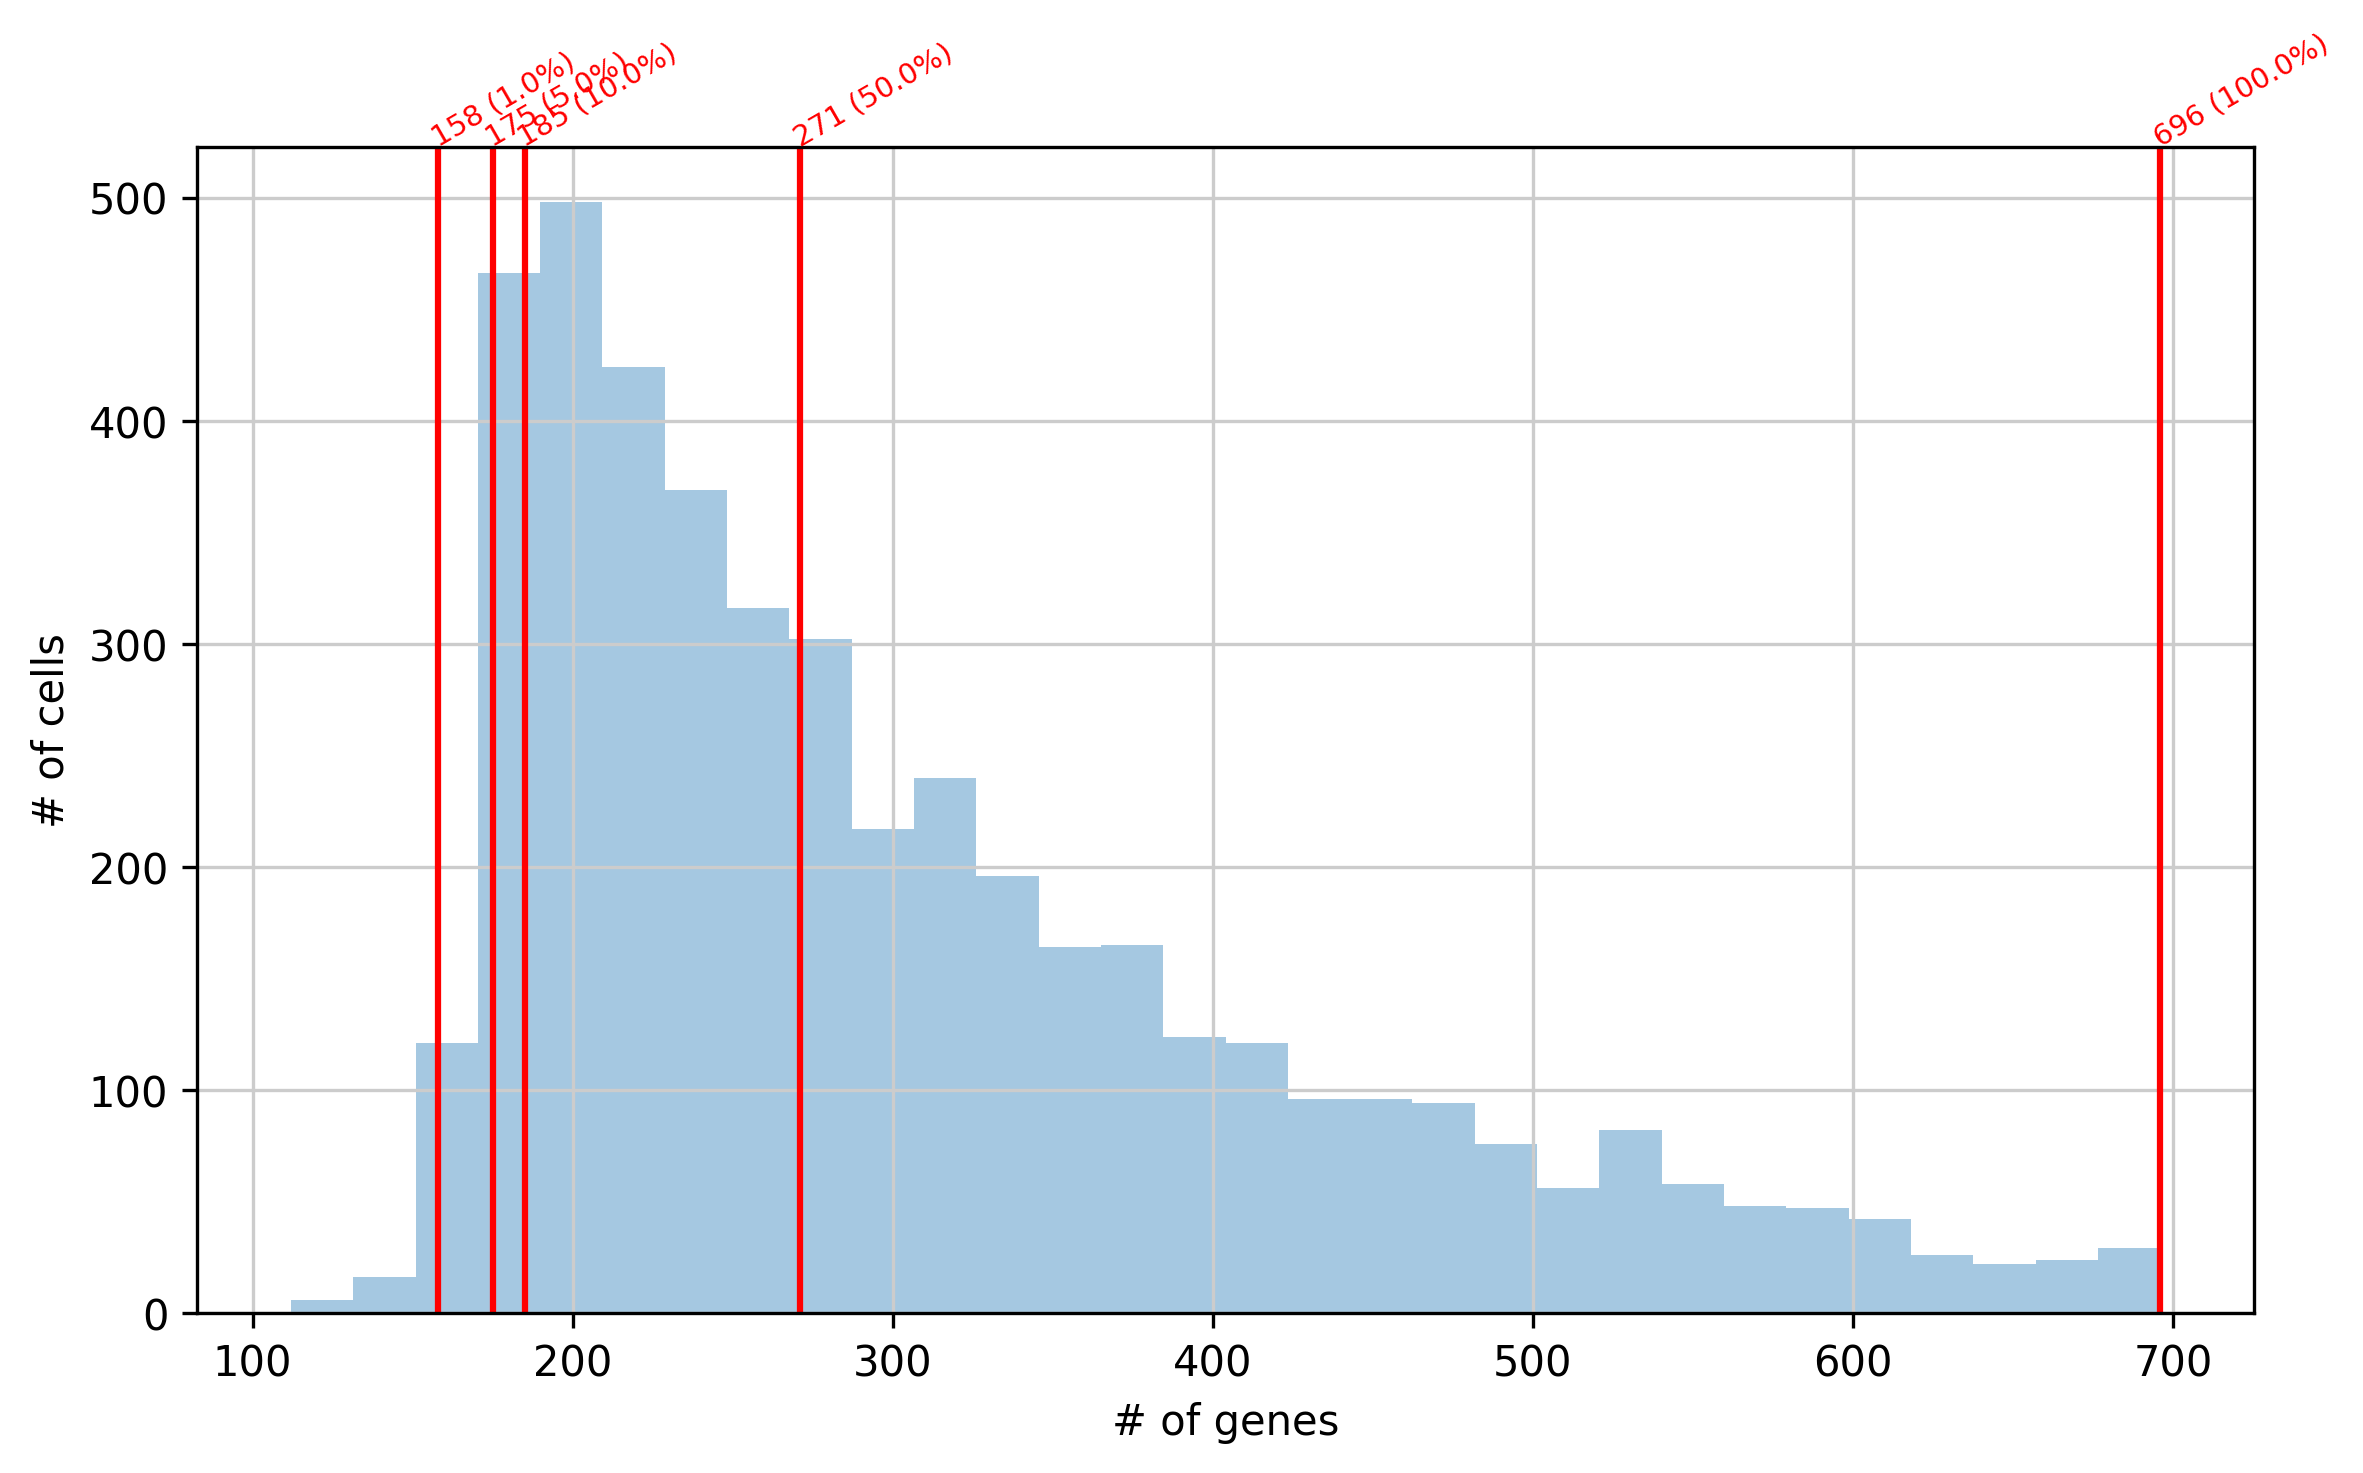

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [48]:
adata

AnnData object with n_obs × n_vars = 4541 × 17279
    obs: 'Cell_type', 'group', 'nGene', 'nUMI', 'orig.ident', 'seurat_clusters'

In [49]:
adata.obs

,Cell_type,group,nGene,nUMI,orig.ident,seurat_clusters
CellID,,,,,,
AAACCCAAGAAGTGTT-1_1,Unknown,A1,191,750.323914,A1,1.0
AAACCCACATACCGTA-1_1,Gastrodermal cell,A1,525,1508.096558,A1,2.0
AAACCCACATTCATCT-1_1,Unknown,A1,534,1525.891235,A1,1.0
AAACGAAAGACGTCGA-1_1,Calicoblast,A1,170,677.932312,A1,3.0
AAACGAATCGAACCTA-1_1,Unknown,A1,258,917.114197,A1,1.0
...,...,...,...,...,...,...
TTTGTTGAGGCAGCTA-1_3,Gastrodermal cell,A3,257,922.342163,A3,2.0
TTTGTTGCACGAAAGC-1_3,Neurons,A3,200,776.774719,A3,5.0
TTTGTTGTCAGCTTCC-1_3,Gastrodermal cell,A3,260,917.237854,A3,2.0


In [50]:
f_loom_path_scenic

'ahem_filtered.loom'

In [5]:
f_pyscenic_output='../output_data/ahem_pyscenic_output_filtered.loom'

In [90]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    ../output_data/reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20


2023-04-17 20:31:44,262 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2023-04-17 20:31:45,648 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2023-04-17 20:31:47,994 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2023-04-17 20:33:08,956 - pyscenic.cli.pyscenic - INFO - Writing results to file.

2023-04-17 20:44:43,618 - pyscenic.cli.pyscenic - ERROR - Expression matrix should be provided in the loom file format.
^C


## Visualization of SCENIC's AUC matrix

In [170]:
# load the needed file
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [53]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "../output_data/scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "../output_data/scenic_tsne.txt", sep='\t')

# Integrate the output

In [ ]:
# set a working directory
wdir = "/Acropora_sc_analysis/scenic_analysis/ahem_TF_analysis/analysis_on_promoter5k/input_data"
os.chdir( wdir )
import json
import zlib
import base64

#f_pyscenic_output='../output_data/ahem_pyscenic_output_filtered.loom'

# combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( '../output_data/scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( '../output_data/scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [284]:
lp.__version__

'3.0.6'

In [285]:
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )

In [286]:
auc_mtx.columns

Index(['g101(+)', 'g10139(+)', 'g11941(+)', 'g11991(+)', 'g12000(+)',
       'g12027(+)', 'g12104(+)', 'g12111(+)', 'g12415(+)', 'g12422(+)',
       ...
       'g8143(+)', 'g8260(+)', 'g8262(+)', 'g8263(+)', 'g844(+)', 'g848(+)',
       'g9036(+)', 'g9037(+)', 'g9179(+)', 'g925(+)'],
      dtype='object', length=178)

In [287]:
# Fix regulon objects to display properly in SCope:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [288]:
f_pyscenic_output

'../output_data/ahem_pyscenic_output_filtered.loom'

In [289]:
f_loom_path_scenic='ahem_filtered.loom'

In [290]:
adata_origin=sc.read_h5ad("ahem.h5ad")

In [291]:
adata_origin

AnnData object with n_obs × n_vars = 4716 × 33509
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'UMI_count_algae', 'gene_count_algae', 'row_name', 'integrated_snn_res.0.08', 'seurat_clusters', 'algae_ratio', 'Cell_type'
    var: 'features'
    obsm: 'X_tsne', 'X_umap'

In [292]:
adata_origin.obs.index

Index(['AAACCCAAGAAGTGTT-1_1', 'AAACCCACATACCGTA-1_1', 'AAACCCACATTCATCT-1_1',
       'AAACGAAAGACGTCGA-1_1', 'AAACGAAGTAGCTTAC-1_1', 'AAACGAATCGAACCTA-1_1',
       'AAACGCTTCGCCAGAC-1_1', 'AAAGAACTCCGTAGGC-1_1', 'AAAGGATCACAGCTGC-1_1',
       'AAATGGAGTTAGAAGT-1_1',
       ...
       'TTTGGAGCAATTCTTC-1_3', 'TTTGGAGGTCGATGCC-1_3', 'TTTGGAGGTTGCGGCT-1_3',
       'TTTGGTTAGTATTGCC-1_3', 'TTTGGTTTCTACTTCA-1_3', 'TTTGTTGAGGCAGCTA-1_3',
       'TTTGTTGCACGAAAGC-1_3', 'TTTGTTGTCAGCTTCC-1_3', 'TTTGTTGTCCACATAG-1_3',
       'TTTGTTGTCCGAAGGA-1_3'],
      dtype='object', length=4716)

In [293]:
dr_tsne

,X,Y
AAACCCAAGAAGTGTT-1_1,-6.940825,-1.696269
AAACCCACATACCGTA-1_1,14.585251,-30.469284
AAACCCACATTCATCT-1_1,7.306247,16.713440
AAACGAAAGACGTCGA-1_1,-7.500732,13.689837
AAACGAATCGAACCTA-1_1,-4.235193,16.602141
...,...,...
TTTGTTGAGGCAGCTA-1_3,-1.071100,-21.606464
TTTGTTGCACGAAAGC-1_3,-24.440008,5.226369
TTTGTTGTCAGCTTCC-1_3,-1.307367,-18.860640
TTTGTTGTCCACATAG-1_3,13.442612,-2.382536


In [294]:
adata = sc.read_loom('ahem_filtered.loom',validate=False) 
adata

AnnData object with n_obs × n_vars = 4541 × 17279
    obs: 'Cell_type', 'group', 'nGene', 'nUMI', 'orig.ident', 'seurat_clusters'

In [295]:
adata.obs

,Cell_type,group,nGene,nUMI,orig.ident,seurat_clusters
CellID,,,,,,
AAACCCAAGAAGTGTT-1_1,Unknown,A1,191,750.323914,A1,1.0
AAACCCACATACCGTA-1_1,Gastrodermal cell,A1,525,1508.096558,A1,2.0
AAACCCACATTCATCT-1_1,Unknown,A1,534,1525.891235,A1,1.0
AAACGAAAGACGTCGA-1_1,Calicoblast,A1,170,677.932312,A1,3.0
AAACGAATCGAACCTA-1_1,Unknown,A1,258,917.114197,A1,1.0
...,...,...,...,...,...,...
TTTGTTGAGGCAGCTA-1_3,Gastrodermal cell,A3,257,922.342163,A3,2.0
TTTGTTGCACGAAAGC-1_3,Neurons,A3,200,776.774719,A3,5.0
TTTGTTGTCAGCTTCC-1_3,Gastrodermal cell,A3,260,917.237854,A3,2.0


In [296]:
adata.obsm['X_umap']=dr_umap.to_numpy()

In [297]:
adata.obsm['X_tsne']=dr_tsne.to_numpy()

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  Inplace subsetting along variables dimension.
... storing 'Cell_type' as categorical
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  Inplace subsetting along variables dimension.
... storing 'group' as categorical
/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. 

OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>


Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle


OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>


Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle


Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle


Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle


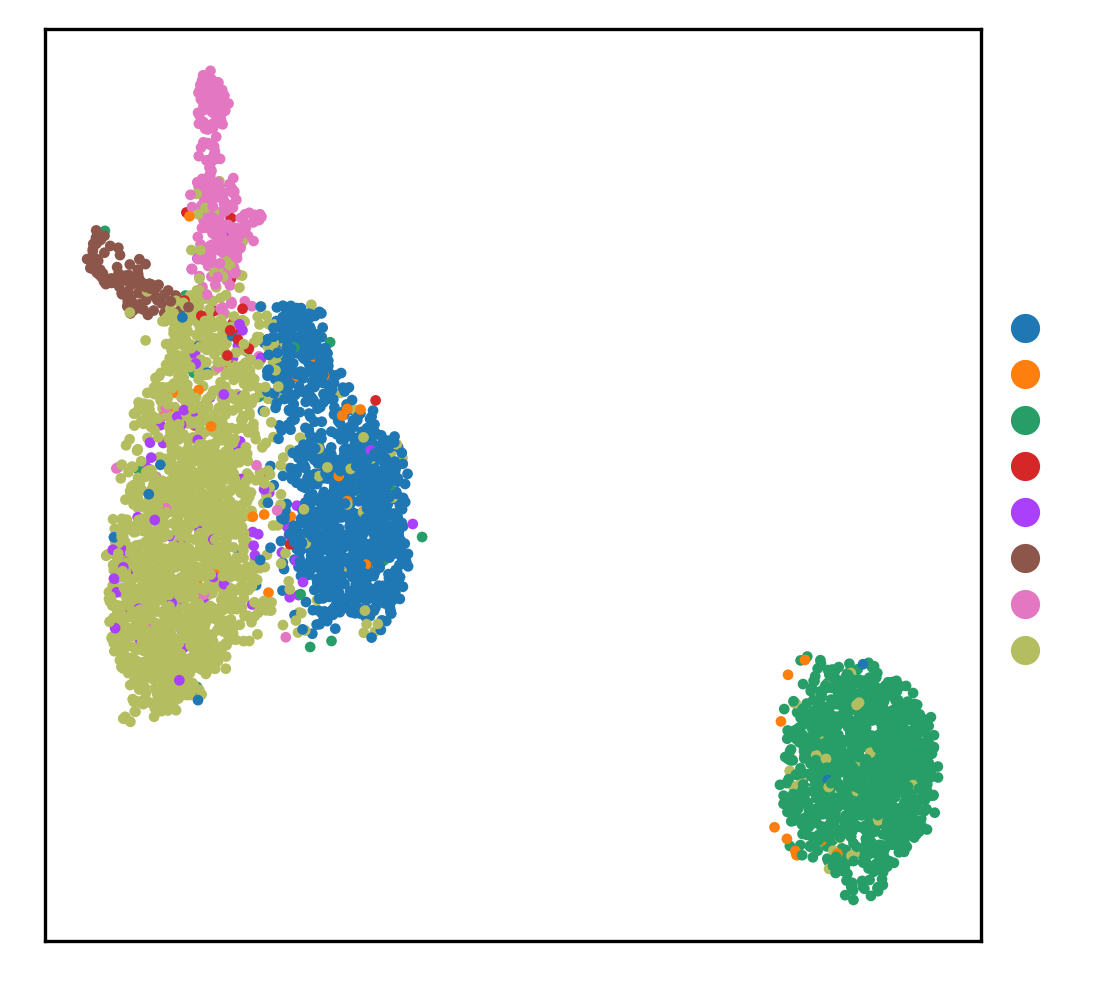

In [298]:
sc.pl.umap(adata, color=['Cell_type'] )

In [239]:
sc.__version__

'1.4.2'

In [71]:
pip install --upgrade scanpy

  Using cached scanpy-1.9.3-py3-none-any.whl (2.0 MB)
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs0000000006d182eb00000344'

Note: you may need to restart the kernel to use updated packages.


In [299]:
#import scanpy as sc
sc.__version__

'1.4.2'

computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle


Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle
Exception ignored in: <_io.BufferedReader name='/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'>
OSError: [Errno 116] Stale file handle


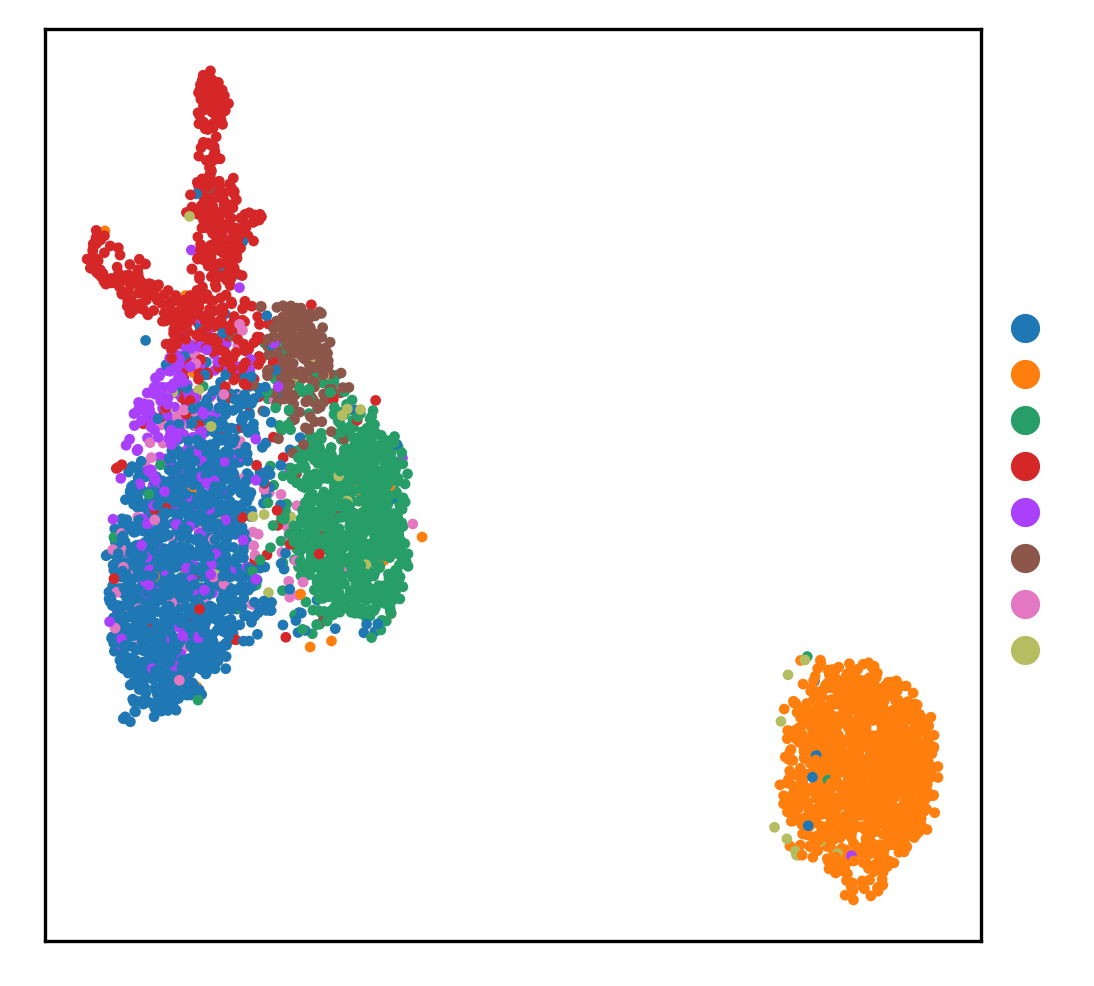

In [300]:
#adata=sc.read_h5ad("/ibex/scratch/projects/c2101/AipSC_analysis_old_genome/scenic_analysis/CC7_apo_sym/CC7_apo.h5ad")
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30) 
import igraph
import louvain
sc.tl.louvain(adata,resolution=0.5)
adata.obs.rename(columns={'nUMI':'n_counts','nGene':'n_genes'},inplace=True)

sc.pl.umap(adata, color=['louvain'] )

# Concatenate embeddings (tSNE, UMAP, etc.)
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [301]:
dr_tsne

,X,Y
AAACCCAAGAAGTGTT-1_1,-6.940825,-1.696269
AAACCCACATACCGTA-1_1,14.585251,-30.469284
AAACCCACATTCATCT-1_1,7.306247,16.713440
AAACGAAAGACGTCGA-1_1,-7.500732,13.689837
AAACGAATCGAACCTA-1_1,-4.235193,16.602141
...,...,...
TTTGTTGAGGCAGCTA-1_3,-1.071100,-21.606464
TTTGTTGCACGAAAGC-1_3,-24.440008,5.226369
TTTGTTGTCAGCTTCC-1_3,-1.307367,-18.860640
TTTGTTGTCCACATAG-1_3,13.442612,-2.382536


In [302]:
dr_umap

,X,Y
AAACCCAAGAAGTGTT-1_1,-1.099414,-1.867059
AAACCCACATACCGTA-1_1,17.992365,-3.240926
AAACCCACATTCATCT-1_1,-1.752691,-1.931420
AAACGAAAGACGTCGA-1_1,3.318459,3.017279
AAACGAATCGAACCTA-1_1,0.842532,2.520214
...,...,...
TTTGTTGAGGCAGCTA-1_3,18.092434,-3.177935
TTTGTTGCACGAAAGC-1_3,0.608103,7.516882
TTTGTTGTCAGCTTCC-1_3,17.441898,-2.345513
TTTGTTGTCCACATAG-1_3,3.651400,-1.120016


In [303]:
adata.obsm['X_umap']

array([[-1.0994142 , -1.8670589 ],
       [17.992365  , -3.2409258 ],
       [-1.7526914 , -1.9314203 ],
       ...,
       [17.441898  , -2.345513  ],
       [ 3.6514    , -1.1200157 ],
       [-1.0418162 ,  0.65292877]])

In [304]:
adata.obsm['X_pca']

array([[ -1.7670196 ,  -7.960621  ,  -0.85840327, ...,   1.5912117 ,
         -0.9261328 ,   2.4408634 ],
       [ 14.225442  ,   4.7675576 ,  -1.944664  , ...,   1.4844129 ,
          2.1662211 ,   1.660976  ],
       [ -1.966846  , -10.461669  ,  -1.7339352 , ...,  -1.0072858 ,
          1.9084481 ,   2.6234868 ],
       ...,
       [ 10.690741  ,  -4.7733316 ,  -5.1911755 , ...,  -0.35104775,
         -1.004098  ,  -0.91993874],
       [  0.44158083,   4.5624833 ,  -8.462864  , ...,   0.29597503,
          2.1758177 ,  -4.399758  ],
       [ -2.4982321 ,  -7.641733  ,   2.0466352 , ...,   3.3050659 ,
          1.0050393 ,  -0.5670196 ]], dtype=float32)

In [305]:
Embeddings_X

,1,2,3,4
AAACCCAAGAAGTGTT-1_1,-1.099414,-1.767020,-6.940825,-1.099414
AAACCCACATACCGTA-1_1,17.992365,14.225442,14.585251,17.992365
AAACCCACATTCATCT-1_1,-1.752691,-1.966846,7.306247,-1.752691
AAACGAAAGACGTCGA-1_1,3.318459,-8.843847,-7.500732,3.318459
AAACGAATCGAACCTA-1_1,0.842532,-3.727693,-4.235193,0.842532
...,...,...,...,...
TTTGTTGAGGCAGCTA-1_3,18.092434,12.362346,-1.071100,18.092434
TTTGTTGCACGAAAGC-1_3,0.608103,-1.493990,-24.440008,0.608103
TTTGTTGTCAGCTTCC-1_3,17.441898,10.690741,-1.307367,17.441898
TTTGTTGTCCACATAG-1_3,3.651400,0.441581,13.442612,3.651400


In [306]:
Embeddings_Y

,1,2,3,4
AAACCCAAGAAGTGTT-1_1,-1.867059,-7.960621,-1.696269,-1.867059
AAACCCACATACCGTA-1_1,-3.240926,4.767558,-30.469284,-3.240926
AAACCCACATTCATCT-1_1,-1.931420,-10.461669,16.713440,-1.931420
AAACGAAAGACGTCGA-1_1,3.017279,11.270648,13.689837,3.017279
AAACGAATCGAACCTA-1_1,2.520214,-4.225803,16.602141,2.520214
...,...,...,...,...
TTTGTTGAGGCAGCTA-1_3,-3.177935,1.186153,-21.606464,-3.177935
TTTGTTGCACGAAAGC-1_3,7.516882,-4.098973,5.226369,7.516882
TTTGTTGTCAGCTTCC-1_3,-2.345513,-4.773332,-18.860640,-2.345513
TTTGTTGTCCACATAG-1_3,-1.120016,4.562483,-2.382536,-1.120016


In [307]:
adata.obs

,Cell_type,group,n_genes,n_counts,orig.ident,seurat_clusters,louvain
CellID,,,,,,,
AAACCCAAGAAGTGTT-1_1,Unknown,A1,191,750.323914,A1,1.0,0
AAACCCACATACCGTA-1_1,Gastrodermal cell,A1,525,1508.096558,A1,2.0,1
AAACCCACATTCATCT-1_1,Unknown,A1,534,1525.891235,A1,1.0,0
AAACGAAAGACGTCGA-1_1,Calicoblast,A1,170,677.932312,A1,3.0,5
AAACGAATCGAACCTA-1_1,Unknown,A1,258,917.114197,A1,1.0,0
...,...,...,...,...,...,...,...
TTTGTTGAGGCAGCTA-1_3,Gastrodermal cell,A3,257,922.342163,A3,2.0,1
TTTGTTGCACGAAAGC-1_3,Neurons,A3,200,776.774719,A3,5.0,3
TTTGTTGTCAGCTTCC-1_3,Gastrodermal cell,A3,260,917.237854,A3,2.0,1


In [308]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        } 
    #{
    #        "name": "Percent_mito"
    #    }
]

metaJson["annotations"] = [
    {
        "name": "Seurat_clusters",
        "values": list(set( adata.obs['seurat_clusters'].astype(np.str) ))
    },
    {
        "name": "Cell_type",
        "values": list(set(adata.obs['Cell_type'].values))
    },
    {
        "name": "group",
        "values": list(set(adata.obs['group'].values))
    },
    {
        "name": "orig.ident",
        "values": list(set(adata.obs['orig.ident'].values))
    },
    #{
    #    "name": "celltype.stim",
    #    "values": list(set(adata.obs['celltype.stim'].values))
    #}
    
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['seurat_clusters']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['seurat_clusters'].values.astype(np.int64)

/home/zhonh0b/anaconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [309]:
# Assemble loom file row and column attributes
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values.astype(np.float32)]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [275]:
dfToNamedMatrix(Embeddings_X).astype(np.float32)#
#auc_mtx.dtypes.index

TypeError: Cannot cast array data from dtype([('1', '<f8'), ('2', '<f4'), ('3', '<f8'), ('4', '<f8')]) to dtype('float32') according to the rule 'unsafe'

In [199]:
adata

AnnData object with n_obs × n_vars = 4541 × 17279
    obs: 'Cell_type', 'group', 'n_genes', 'n_counts', 'orig.ident', 'seurat_clusters', 'louvain'
    uns: 'Cell_type_colors', 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_umap', 'X_tsne', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [310]:
adata

AnnData object with n_obs × n_vars = 4541 × 17279
    obs: 'Cell_type', 'group', 'n_genes', 'n_counts', 'orig.ident', 'seurat_clusters', 'louvain'
    uns: 'Cell_type_colors', 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_umap', 'X_tsne', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [311]:
adata.obs.rename(columns={'group':'Group'},inplace=True)

In [312]:
adata.obs.rename(columns={'seurat_clusters':'Seurat_clusters'},inplace=True)

In [313]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Seurat_clusters": np.array( adata.obs['Seurat_clusters'].values ),
    "Cell_type": np.array(adata.obs['Cell_type'].values),
    "Group": np.array(adata.obs['Group'].values),
    "orig.ident": np.array(adata.obs['orig.ident'].values),
    "Seurat_clusters": np.array(adata.obs['Seurat_clusters'].values),
    #"celltype.stim": np.array(adata.obs['celltype.stim'].values),
    #"Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['Seurat_clusters'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "ahem_filtered_samples_pyscenic_final_output_for_RNA_assay",
    "MetaData": json.dumps(metaJson),
    "Genome": 'ahemprechii',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [314]:
col_attrs['Embeddings_X'].dtype

dtype([('1', '<f8'), ('2', '<f4'), ('3', '<f8'), ('4', '<f8')])

In [315]:
f_final_loom='../output_data/ahem_scenic_integrated-output.loom'

In [316]:
lf

,,CellID,AAACCCAAGAAGTGTT-1_1,AAACCCACATACCGTA-1_1,AAACCCACATTCATCT-1_1,AAACGAAAGACGTCGA-1_1,AAACGAATCGAACCTA-1_1,AAACGCTTCGCCAGAC-1_1,AAAGAACTCCGTAGGC-1_1,AAAGGATCACAGCTGC-1_1,AAATGGAGTTAGAAGT-1_1,AAATGGATCCATGAGT-1_1,...
,,Cell_type,Unknown,Gastrodermal cell,Unknown,Calicoblast,Unknown,Calicoblast,Unknown,Unknown,Gastrodermal cell,Unknown,...
,,RegulonsAUC,"(0.0536474, 0.03047416, 0.04102596, 0.02652048, 0.04004241, 0.03018084, 0.02020633, 0.05349963, 0.037983, 0.02729195, 0.03721285, 0.03153012, 0.05687102, 0.08128307, 0.05141237, 0.02556288, 0.03850417, 0.03870617, 0.04792265, 0.02952995, 0.03556829, 0.08963252, 0.03158539, 0.04328181, 0.02977978, 0.0332338, 0.0290815, 0.03605891, 0.0338405, 0.02980141, 0.03679071, 0.02502894, 0.03213652, 0.03079611, 0.02314815, 0.07198184, 0.01085993, 0.02612786, 0.02290448, 0.08417061, 0.01746476, 0.02855295, 0.04419407, 0.02483345, 0.02223876, 0.0556087, 0.02648296, 0.03513007, 0.03384114, 0.02707012, 0.02847994, 0.02945019, 0.02831851, 0.03123388, 0.03176121, 0.03484881, 0.03536616, 0.03673066, 0.02744034, 0.04984338, 0.04942764, 0.02695935, 0.0413214, 0.02354764, 0.03479621, 0.0370679, 0.03921109, 0.01348631, 0.03487319, 0.02343869, 0.02065603, 0.0462037, 0.10887235, 0.06398534, 0.02813611, 0.01442208, 0.02136917, 0.02945302, 0.02234492, 0.02487125, 0.02635937, 0.0280641, 0.02363782, 0.04501308, 0.03881266, 0.07183939, 0.03020658, 0.03165549, 0.02805788, 0.12988281, 0.03323725, 0.04102956, 0.03183044, 0.03121391, 0.13439658, 0.03664009, 0.02353098, 0.05436992, 0.04609119, 0.0469723, 0.08425052, 0.03539629, 0.02594441, 0.03207747, 0.01905706, 0.02395387, 0.07339015, 0.10723978, 0.03753734, 0.03224625, 0.03229407, 0.02843915, 0.04010807, 0.0224843, 0.03347702, 0.04358406, 0.0142087, 0.05579551, 0.03132814, 0.0582706, 0.04214272, 0.03111406, 0., 0.04062943, 0.01357916, 0.02918091, 0.03123606, 0.0425704, 0.04624557, 0.02506103, 0.03759431, 0.03609311, 0.02302189, 0.02737269, 0.03309649, 0.04371521, 0.03169001, 0.02561393, 0.05464901, 0.03495887, 0.02666729, 0.0349759, 0.02306488, 0.03287338, 0.04411286, 0.03957504, 0.05970293, 0.02749183, 0.02672261, 0.05243214, 0.03316388, 0.0272875, 0.03662007, 0.04900632, 0.05045351, 0.03298243, 0.02824625, 0.03585842, 0.01299155, 0.02612218, 0.02741792, 0.03063166, 0.03482598, 0.01981033, 0.0722174, 0.0157032, 0.04454634, 0.0325168, 0.01725589, 0.03742678, 0.021813, 0.00702824, 0.0485755, 0.05113812, 0.07852366, 0., 0.0258276, 0.03351582)","(0.04511108, 0.07210903, 0.03081597, 0.03213765, 0.09386671, 0.0473383, 0.03126756, 0.0533575, 0.04609474, 0.07646748, 0.05648221, 0.04401188, 0.06778736, 0.07912257, 0.1009796, 0.08782974, 0.0826215, 0.07801783, 0.05584491, 0.04407457, 0.05103343, 0.05222512, 0.05566735, 0.05695491, 0.04562201, 0.04820868, 0.03966964, 0.01929628, 0.04657198, 0.04120664, 0.04328299, 0.0510706, 0.04691194, 0.04488358, 0.03036077, 0.04313568, 0.10593972, 0.06134259, 0.06472344, 0.04971927, 0.0469441, 0.03779435, 0.06676587, 0.06410061, 0.0288617, 0.07881, 0.03180594, 0.04964175, 0.05016327, 0.03683575, 0.04030478, 0.05315281, 0.03906798, 0.04286599, 0.04459608, 0.1325774, 0.08767677, 0.05151436, 0.09125972, 0.06175719, 0.05661783, 0.03142785, 0.04002646, 0.03079824, 0.0280526, 0.04923354, 0.0704298, 0.09673578, 0.03294418, 0.04127134, 0.10556048, 0.14589506, 0.05455357, 0.06012731, 0.03877773, 0.04790886, 0.08639832, 0.05181987, 0.14184882, 0.0352294, 0.04109688, 0.040479, 0.03427707, 0.15058877, 0.05513257, 0.08982372, 0.05224993, 0.0474537, 0.04973681, 0.17928964, 0.13186801, 0.0559272, 0.03742979, 0.09053284, 0.08609934, 0.04904441, 0.03120548, 0.06137082, 0.08252754, 0.05984718, 0.11676712, 0.03863478, 0.02836508, 0.03101695, 0.0282092, 0.04016471, 0.0625, 0.09754151, 0.03401284, 0.05823664, 0.09166529, 0.13734568, 0.04091755, 0.05282861, 0.03945218, 0.06130773, 0.14566581, 0.1023741, 0.04925574, 0.07572906, 0.05175168, 0.03300553, 0.07858796, 0.04852889, 0.14110589, 0.06169516, 0.03790858, 0.03657725, 0.05628873, 0.06042719, 0.0

In [317]:
# Create a new loom file, copying the expression matrix from the open loom connection
lp.create(
    filename = f_final_loom , #it original would be: 
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

In [329]:
lf.col_attrs['RegulonsAUC'].dtype

dtype([('g101_(+)', '<f8'), ('g10139_(+)', '<f8'), ('g11941_(+)', '<f8'), ('g11991_(+)', '<f8'), ('g12000_(+)', '<f8'), ('g12027_(+)', '<f8'), ('g12104_(+)', '<f8'), ('g12111_(+)', '<f8'), ('g12415_(+)', '<f8'), ('g12422_(+)', '<f8'), ('g12536_(+)', '<f8'), ('g12549_(+)', '<f8'), ('g13091_(+)', '<f8'), ('g13263_(+)', '<f8'), ('g13264_(+)', '<f8'), ('g13305_(+)', '<f8'), ('g13309_(+)', '<f8'), ('g13396_(+)', '<f8'), ('g13489_(+)', '<f8'), ('g13636_(+)', '<f8'), ('g138_(+)', '<f8'), ('g14900_(+)', '<f8'), ('g1505_(+)', '<f8'), ('g1519_(+)', '<f8'), ('g15328_(+)', '<f8'), ('g15394_(+)', '<f8'), ('g15420_(+)', '<f8'), ('g15803_(+)', '<f8'), ('g16349_(+)', '<f8'), ('g16563_(+)', '<f8'), ('g16711_(+)', '<f8'), ('g16750_(+)', '<f8'), ('g16753_(+)', '<f8'), ('g16780_(+)', '<f8'), ('g16958_(+)', '<f8'), ('g17088_(+)', '<f8'), ('g181_(+)', '<f8'), ('g18721_(+)', '<f8'), ('g18785_(+)', '<f8'), ('g18786_(+)', '<f8'), ('g18885_(+)', '<f8'), ('g19255_(+)', '<f8'), ('g19302_(+)', '<f8'), ('g19717_(+)

In [334]:
lf = lp.connect( '../output_data/ahem_scenic_integrated-output.loom', mode='r+', validate=False )

In [335]:
lf

,,CellID,AAACCCAAGAAGTGTT-1_1,AAACCCACATACCGTA-1_1,AAACCCACATTCATCT-1_1,AAACGAAAGACGTCGA-1_1,AAACGAATCGAACCTA-1_1,AAACGCTTCGCCAGAC-1_1,AAAGAACTCCGTAGGC-1_1,AAAGGATCACAGCTGC-1_1,AAATGGAGTTAGAAGT-1_1,AAATGGATCCATGAGT-1_1,...
,,Cell_type,Unknown,Gastrodermal cell,Unknown,Calicoblast,Unknown,Calicoblast,Unknown,Unknown,Gastrodermal cell,Unknown,...
,,ClusterID,1.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,2.0,1.0,...
,,Clusterings,"(1,)","(2,)","(1,)","(3,)","(1,)","(3,)","(1,)","(1,)","(2,)","(1,)",...
,,Embedding,"(-6.94082451, -1.69626856)","(14.58525085, -30.46928406)","(7.30624676, 16.71343994)","(-7.50073147, 13.6898365)","(-4.23519325, 16.60214043)","(14.12004566, 2.44392538)","(4.20527935, 20.88386917)","(-4.71933126, 5.98954916)","(10.47846317, -20.46819687)","(-15.16756344, 14.43415546)",...
,,Embeddings_X,"(-1.09941423, -1.7670196, -6.94082451, -1.09941423)","(17.99236488, 14.225442, 14.58525085, 17.99236488)","(-1.75269139, -1.966846, 7.30624676, -1.75269139)","(3.31845927, -8.843847, -7.50073147, 3.31845927)","(0.84253246, -3.7276928, -4.23519325, 0.84253246)","(3.36649179, -9.644602, 14.12004566, 3.36649179)","(-0.31685165, -3.966611, 4.20527935, -0.31685165)","(-1.88153708, -0.72479355, -4.71933126, -1.88153708)","(15.96148872, 11.274259, 10.47846317, 15.96148872)","(-0.54962575, -4.200146, -15.16756344, -0.54962575)",...
,,Embeddings_Y,"(-1.86705887, -7.960621, -1.69626856, -1.86705887)","(-3.24092579, 4.7675576, -30.46928406, -3.24092579)","(-1.93142033, -10.461669, 16.71343994, -1.93142033)","(3.01727915, 11.270648, 13.6898365, 3.01727915)","(2.52021432, -4.2258034, 16.60214043, 2.52021432)","(0.64288181, 7.0816073, 2.44392538, 0.64288181)","(0.53264248, -2.4549813, 20.88386917, 0.53264248)","(0.74706095, -6.226448, 5.98954916, 0.74706095)","(-3.66865087, 7.0182066, -20.46819687, -3.66865087)","(3.34960413, 2.1321902, 14.43415546, 3.34960413)",...
,,Group,A1,A1,A1,A1,A1,A1,A1,A1,A1,A1,...
,,RegulonsAUC,"(0.0536474, 0.03047416, 0.04102596, 0.02652048, 0.0400424, 0.03018084, 0.02020633, 0.05349964, 0.037983, 0.02729195, 0.03721284, 0.03153012, 0.05687102, 0.08128307, 0.05141237, 0.02556288, 0.03850417, 0.03870617, 0.04792265, 0.02952995, 0.03556829, 0.08963253, 0.03158538, 0.0432818, 0.02977978, 0.0332338, 0.0290815, 0.03605891, 0.0338405, 0.02980141, 0.03679071, 0.02502893, 0.03213653, 0.03079611, 0.02314815, 0.07198184, 0.01085993, 0.02612786, 0.02290448, 0.08417061, 0.01746476, 0.02855296, 0.04419407, 0.02483345, 0.02223876, 0.0556087, 0.02648296, 0.03513007, 0.03384114, 0.02707012, 0.02847994, 0.02945019, 0.02831851, 0.03123388, 0.03176121, 0.03484881, 0.03536616, 0.03673067, 0.02744034, 0.04984337, 0.04942764, 0.02695935, 0.0413214, 0.02354764, 0.03479621, 0.0370679, 0.03921109, 0.01348631, 0.03487319, 0.02343869, 0.02065603, 0.0462037, 0.10887235, 0.06398534, 0.02813611, 0.01442208, 0.02136917, 0.02945302, 0.02234492, 0.02487125, 0.02635937, 0.0280641, 0.02363782, 0.04501309, 0.03881266, 0.07183938, 0.03020658, 0.03165549, 0.02805788, 0.12988281, 0.03323724, 0.04102956, 0.03183044, 0.03121391, 0.13439658, 0.03664009, 0.02353098, 0.05436992, 0.04609119, 0.0469723, 0.08425052, 0.03539629, 0.02594441, 0.03207747, 0.01905706, 0.02395387, 0.07339015, 0.10723978, 0.03753734, 0.03224625, 0.03229407, 0.02843915, 0.04010807, 0.0224843, 0.03347702, 0.04358406, 0.0142087, 0.05579551, 0.03132814, 0.0582706, 0.04214272, 0.03111406, 0., 0.04062943, 0.01357916, 0.02918091, 0.03123606, 0.0425704, 0.04624557, 0.02506103, 0.03759431, 0.03609311, 0.02302189, 0.02737268, 0.0330965, 0.04371521, 0.03169001, 0.02561393, 0.05464901, 0.03495887, 0.02666729, 0.0349759, 0.02306488, 0.03287338, 0.04411286, 0.03957504, 0.05970293, 0.02749183, 0.02672261, 0.05243214, 0.03316388, 0.0272875, 0.03662007, 0.04900632, 0.05045351, 0.03298242, 0.02824625, 0.03585842, 0.01299155, 0.02612218, 0.02741792, 0.03063166, 0.03482598, 0.01981033, 0.0722174, 0.0157032, 0.04454634, 0.0325168, 0.01725589, 0.03742678, 0.021813, 0.00702824, 0.0485755, 0.05113812, 0.0785236

In [336]:
lf.close()